# Intro to GDAL and more

This notebook will provide some basic usage examples of interacting with images using GDAL and other libraries. 
It is assumed that the sample imagery has already been downloaded and is sitting in a subfolder `ls8/`.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import gdal
from utils import ls8tools

# Store the directory path where the landsat images are stored.
BASE_DIR = os.path.join(os.getcwd(), 'ls8')
# Get a list of the images
ALL_LS8 = os.listdir(BASE_DIR)
print(ALL_LS8)

['.DS_Store', 'LC80480232014249LGN00_B2.TIF', 'LC80480232014249LGN00_B2_subset.TIF', 'LC80480232014249LGN00_B3.TIF', 'LC80480232014249LGN00_B3_subset.TIF', 'LC80480232014249LGN00_B4.TIF', 'LC80480232014249LGN00_B4_subset.TIF', 'LC80480232014249LGN00_B4_subset_pan.TIF', 'LC80480232014249LGN00_B5.TIF', 'LC80480232014249LGN00_B5_subset.TIF', 'LC80480232014249LGN00_B5_subset_pan.TIF', 'LC80480232014249LGN00_B6.TIF', 'LC80480232014249LGN00_B6_subset.TIF', 'LC80480232014249LGN00_B8.TIF', 'LC80480232014249LGN00_B8_subset.TIF', 'LC80480232014249LGN00_MTL.txt']


In [3]:
# Create a helper function for getting band filenames
def get_band_filename(band_num):
    band_id = 'B{0}'.format(band_num)
    for img_file in ALL_LS8:
        if band_id in img_file:
            return os.path.join(BASE_DIR, img_file)

In [4]:
# Open a single band with GDAL
file_b8 = get_band_filename(8)
img_pan = gdal.Open(file_b8)

In [5]:
# Get the raster projection
print(img_pan.GetProjectionRef())

PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32610"]]


In [6]:
# Get some of the properties of the raster
print('Num of Rasters:', img_pan.RasterCount)
print('Pixel width:', img_pan.RasterXSize)
print('Pixel height:', img_pan.RasterYSize)
geo_trans = img_pan.GetGeoTransform()
print('Top Left (origin) x:', geo_trans[0])
print('Top Left (origin) y:', geo_trans[3])
print('Pixel Width:', geo_trans[1])
print('Pixel Height:', geo_trans[5])

Num of Rasters: 1
Pixel width: 15861
Pixel height: 16061
Top Left (origin) x: 415492.5
Top Left (origin) y: 6003607.5
Pixel Width: 15.0
Pixel Height: -15.0


In [7]:
# Get the data type of the raster
band = img_pan.GetRasterBand(1)
band_type = gdal.GetDataTypeName(band.DataType)
print(band_type)

UInt16


In [66]:
# Let's open the rest of the bands
img_blue = gdal.Open(get_band_filename(2))
img_green = gdal.Open(get_band_filename(3))
img_red = gdal.Open(get_band_filename(4))
img_nir = gdal.Open(get_band_filename(5))
img_swir = gdal.Open(get_band_filename(6))

## Display images

<IPython.core.display.Javascript object>


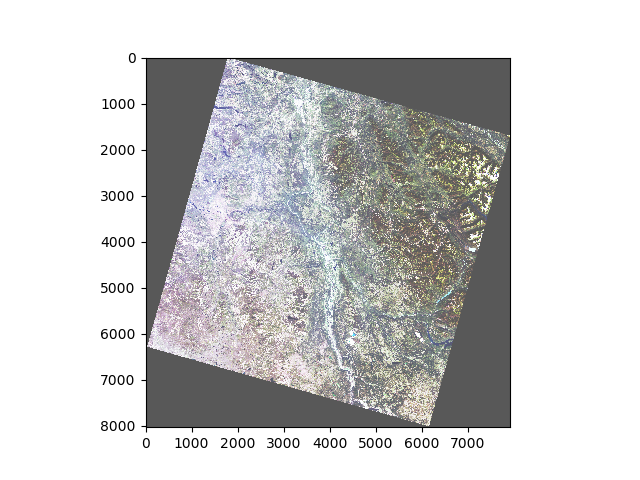

In [40]:
# Display RGB, Be patient...
ls8tools.show([img_red, img_green, img_blue], enhance=['equ'])

## Subset Images

In [10]:
# Easiest to use the command line gdal_translate
# gdal_translate -projwin ulx uly lrx lry src_filename dest_filename
# The function ls8tools.subset_raster() is a wrapper around this. 
subset_coords = [495000, 5983000, 540000, 5950000]
img_blue_subset = ls8tools.subset_raster(img_blue, subset_coords)
img_green_subset = ls8tools.subset_raster(img_green, subset_coords)
img_red_subset = ls8tools.subset_raster(img_red, subset_coords)
img_nir_subset = ls8tools.subset_raster(img_nir, subset_coords)
img_swir_subset = ls8tools.subset_raster(img_swir, subset_coords)
img_pan_subset = ls8tools.subset_raster(img_pan, subset_coords)

<IPython.core.display.Javascript object>


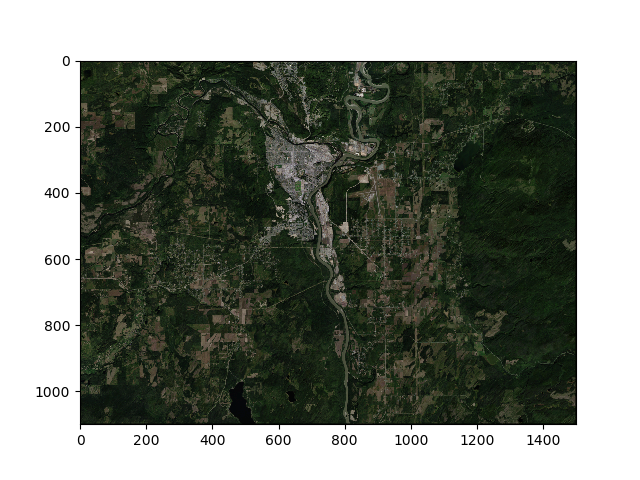

In [43]:
# Display the subset
ls8tools.show([img_red_subset, img_green_subset, img_blue_subset])

<IPython.core.display.Javascript object>


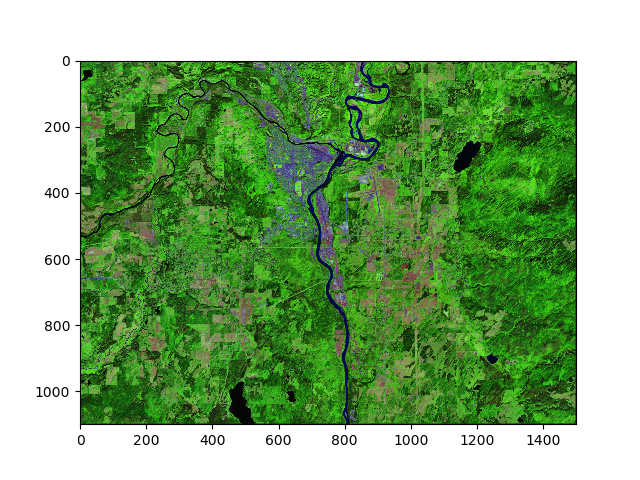

In [44]:
ls8tools.show([img_swir_subset, img_nir_subset, img_red_subset])

## Pansharpening

In [84]:
# Pan sharpen each band
img_rgb_pan = ls8tools.pansharpen([img_red_subset, img_green_subset, img_blue_subset], img_pan_subset)

6753


In [85]:
print('MS Pixels:', img_red_subset.GetGeoTransform()[1], img_red_subset.GetGeoTransform()[5])
print('MS_pan Pixels:', img_rgb_pan.GetGeoTransform()[1], img_rgb_pan.GetGeoTransform()[5])

MS Pixels: 30.0 -30.0
MS_pan Pixels: 15.0 -15.0


<IPython.core.display.Javascript object>


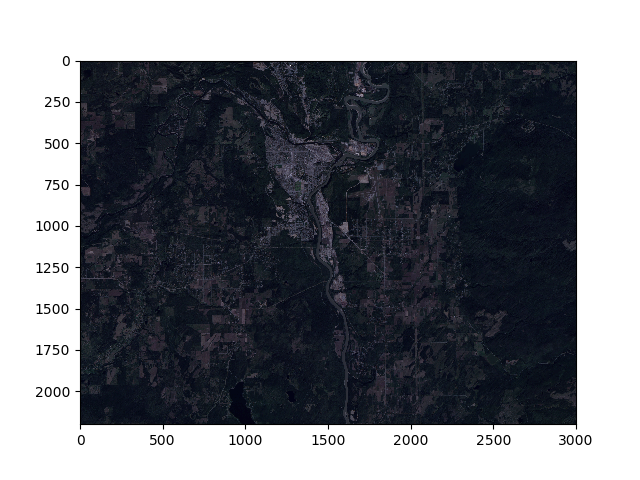

In [98]:
ls8tools.show(img_rgb_pan)

## Create an Index

<IPython.core.display.Javascript object>


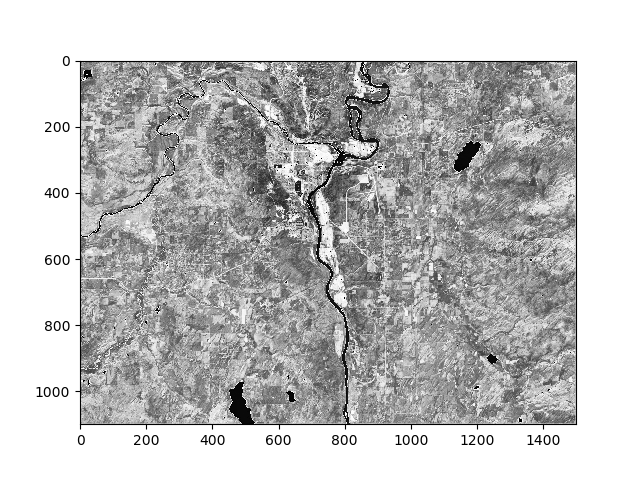

In [75]:
# Create NDVI
img_ndvi = ls8tools.ndvi(img_red_subset, img_nir_subset)
ls8tools.show(img_ndvi)

## Classification

In [115]:
# Create the new dataset with
kmeans = ls8tools.kmeans(img_rgb_pan, n_clusters=10)

<IPython.core.display.Javascript object>


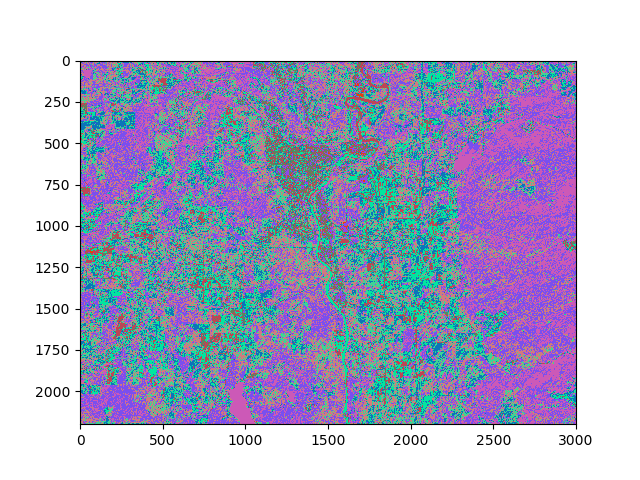

In [118]:
ls8tools.show(kmeans, cmap=10, enhance=[])

## Time Left?

Try a supervised classification, follow this blog post: http://www.machinalis.com/blog/python-for-geospatial-data-processing/

# Where To Go From Here

For this workshop, we looked at the most common libraries when it comes to basic processing of imagery. However, there are many great libraries available that may provide better, easier to use, or more efficient tools for the same tasks. This will be left up to the users to explore for their use case, however here is a list of the more well known ones to start with:

- [scikit-image](http://scikit-image.org/) Used in this workshop.
- [scikit-learn](http://scikit-learn.org/stable/) Used in this workshop.
- [rsgislib](http://www.rsgislib.org/)
- [pyproj](http://jswhit.github.io/pyproj/)
- [shapely](http://toblerity.org/shapely/manual.html)
- [OpenCV](http://opencv.org/)

And many more. Good Luck.